## Import

In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import Tuple
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

## Env

In [ ]:
import numpy as np
from typing import Tuple

class GridWorldEnvironment:
    def __init__(self, start_point:Tuple, end_point:Tuple, gridworld_size:Tuple):
        # 시작점과 끝점을 받는다.
        self.start_point = start_point
        self.end_point = end_point

        # 그리드 월드의 규격을 받는다.
        self.height, self.width = gridworld_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right']
        self.num_actions = len(self.action_space)
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) }

        # 위치 : 좌표로 나타남
        self.present_coords = start_point
        self.traces = []

        self.state_len = 15
        self.num_obs = 3 # 움직이는 장애물
        self.obs_coords = self.init_obs()

    def init_obs(self): # 장애물의 초기 위치 설정
        obs_coords = []
        while len(obs_coords) < self.num_obs:
            coord = (np.random.randint(0, self.height), np.random.randint(0, self.width))
            if coord != self.start_point and coord != self.end_point and coord not in obs_coords:
                obs_coords.append(coord)
        return obs_coords

    def render(self):
        # 그리드 월드의 상태를 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        # 지나간 흔적
        traces = list(set(self.traces)) # 중복행동을 피하기 위해서
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[self.present_coords[0]][self.present_coords[1]] = "A" # 현재 에이전트의 위치

        for obs in self.obs_coords:
            self.grid_world[obs[0]][obs[1]] = "O"

        # string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)

    def reset(self):
        self.present_coords = self.start_point
        self.traces = []
        return self.get_state(self.present_coords)

    def step(self, action_idx:int):
        '''
        에이전트의 행동에 따라 주어지는 next_coords, reward, done
        '''
        # action and movement per action
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_coords = (self.present_coords[0]+row_movement, self.present_coords[1]+col_movement)
        next_coords = self.check_boundary(next_coords)

        self.move_obs() # 장애물 이동, 여기에서 장애물 위치 업데이트

        #  보상 함수
        if next_coords == self.end_point:
            reward = 1
            done = True
        elif next_coords in self.obs_coords: # 장애물이랑 부딪히면
            reward = -1
            done = False
        else:
            reward = 0
            done = False

        # 현재 위치 업데이트
        self.present_coords = next_coords
        # print(f"present: {self.present_coords}")
        self.traces.append(self.present_coords)

        state = self.get_state(self.present_coords)
        # print(f"reward: {reward}")
        # print(f"done: {done}")

        return state, reward, done

    def move_obs(self):
        next_coords = []
        for coord in self.obs_coords:
            action_idx = np.random.choice(self.action_space)
            action = self.actions[action_idx]
            next_coord = (coord[0]+action[0], coord[1]+action[1])
            next_coord = self.check_boundary(next_coord)
            if next_coord == self.end_point:
                next_coords.append(coord)
            else:
                next_coords.append(next_coord)
        self.obs_coords = next_coords
        # print(f"obs_coords: {self.obs_coords}")

    def get_state(self, present_coords):
        '''
        1. 에이전트와 목적지의 상대적인 위치 (x, y)
        2. 목적지의 라벨 (0, 1)
        3. 에이전트와 장애물의 상대적인 위치 (x, y)
        4. 장애물의 라벨 (0, 1)
        5. 장애물의 속도
        '''
        states = list()

        # 1. 에이전트에 대한 목적지의 상대적인 위치 (x, y)
        states.append(self.end_point[0] - present_coords[0])
        states.append(self.end_point[1] - present_coords[1])

        # 2. 목적지의 라벨
        if present_coords == self.end_point:
            states.append(1)
        else:
            states.append(0)

        # 3. 에이전트에 대한 장애물의 상대적인 위치 (x, y)
        for obs in range(self.num_obs):
            obs = self.obs_coords[obs]
            states.append(obs[0] - present_coords[0])
            states.append(obs[1] - present_coords[1])
            # 4. 장애물 라벨
            if present_coords == obs:
                states.append(1)
            else:
                states.append(0)
            # 5. 장애물 속력
            states.append(1) # 항상 1이다.
        return states

    def check_boundary(self, coords):
        coords = list(coords)
        coords[0] = (0 if coords[0] < 0 else self.height - 1 if coords[0] > self.height - 1 else coords[0])
        coords[1] = (0 if coords[1] < 0 else self.width - 1 if coords[1] > self.width - 1 else coords[1])
        return tuple(coords)

## DNN

In [ ]:
class DNN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc_out = nn.Linear(24, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc_out(x), dim=1) # 출력이 정책이므로 softmax로 확률로 변환
        return x # action_size의 크기의 정책 텐서 반환

## Agent

In [ ]:
class REINFORCEAgent:
    def __init__(self, state_size, action_size):

        self.state_size = state_size
        self.action_size = action_size

        # 하이퍼파라미터
        self.gamma = 0.99
        self.learning_rate = 0.001

        # 정책을 근사할 심층신경망
        self.model = DNN(self.state_size, self.action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr = self.learning_rate)
        self.states, self.actions, self.rewards = [], [], []

    def get_action(self, state):
        # 딥살사와 다르게 정책이 확률적이므로 엡실론-탐욕 정책을 사용하지 않아도 된다.
        self.model.eval() # 모델을 평가 모드로 전환
        state = torch.tensor(state, dtype=torch.float32) # 입력을 토치 텐서로 바꿔줌
        state = state.unsqueeze(0) # 1D -> 2D
        policy = self.model(state)
        policy = policy.squeeze().detach().numpy() # 넘파이 배열로 변환
        if np.isnan(policy).any(): # 정책이 [nan, nan, nan, nan]인 경우가 발생해서 추가
            policy = np.full(shape=(self.action_size), fill_value=0.25)
        return np.random.choice(self.action_size, 1, p=policy)[0]

    def compute_Gt(self, rewards):

        Gt = np.zeros_like(rewards) # rewards: 타임 스텝동안 받은 보상
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = rewards[t] + self.gamma*running_add
            Gt[t] = running_add
        return Gt # [G1, G2, G3...] 반환: 에피소드 길이만큼

    def append_sample(self, state, action, reward):
        # 하나의 에피소드의 샘플을 append
        # 각 리스트는 하나의 에피소드의 타임 스텝만큼의 길이
        self.states.append(state)
        self.rewards.append(reward)
        act = np.zeros(self.action_size)
        act[action] = 1 # 실제로 한 행동만 1
        self.actions.append(act)

    def train_model(self):

        Gt = np.float32(self.compute_Gt(self.rewards))
        Gt -= np.mean(Gt)
        Gt /= np.std(Gt) # 반환값으로 정규화하면 성능이 좋아짐
        Gt = torch.tensor(Gt, dtype=torch.float32)

        self.model.train() # 모델을 훈련 모드로 전환

        self.states = torch.tensor(self.states, dtype=torch.float32)
        self.actions = torch.tensor(self.actions, dtype=torch.float32)
        policy = self.model(self.states) # 정책 텐서 반환
        policy = torch.sum(policy*self.actions, axis=1) # 각 타임 스텝마다 실제로 한 행동의 정책만 남겨둠

        # loss
        loss = -torch.log(policy+1e-5)*Gt
        loss = loss.sum() # 에피소드의 loss

        # 한 번의 에피소드가 끝나면 파라미터 업데이트
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.states, self.actions, self.rewards = [], [], [] # 에피소드의 기록 초기화

## Main loop

In [ ]:
if __name__ == '__main__':

    env = GridWorldEnvironment((0, 0), (4, 4), (5, 5))
    agent = REINFORCEAgent(env.state_len, env.num_actions)

    EPISODES = 1000
    total_moves = []
    scores = []

    for epi in range(EPISODES):
        done = False
        move_cnt = 0
        score = 0
        state = env.reset()
        while not done:
            action_idx = agent.get_action(state)
            next_state, reward, done = env.step(action_idx)
            agent.append_sample(state, action_idx, reward)
            state = next_state
            score += reward
            move_cnt += 1

            if done: # 에피소드가 끝나면
                agent.train_model()
        total_moves.append(move_cnt)
        scores.append(score)

        if epi%100 == 0:
            print(f"EPISODE {epi}: \nNum of Moves Mean: {np.mean(total_moves[-100:]):.4f}\nScore Mean: {np.mean(scores[-100:]):.4f}\n\n")

EPISODE 0: 
Num of Moves Mean: 456.0000
Score Mean: -45.0000


EPISODE 100: 
Num of Moves Mean: 60.7900
Score Mean: -6.4500


EPISODE 200: 
Num of Moves Mean: 25.5900
Score Mean: -1.6300


EPISODE 300: 
Num of Moves Mean: 15.5900
Score Mean: -0.8400


EPISODE 400: 
Num of Moves Mean: 12.5900
Score Mean: -0.4900


EPISODE 500: 
Num of Moves Mean: 11.9800
Score Mean: -0.3200


EPISODE 600: 
Num of Moves Mean: 11.7200
Score Mean: -0.5600


EPISODE 700: 
Num of Moves Mean: 10.9900
Score Mean: -0.2000


EPISODE 800: 
Num of Moves Mean: 10.4000
Score Mean: -0.2400


EPISODE 900: 
Num of Moves Mean: 10.6900
Score Mean: -0.1800




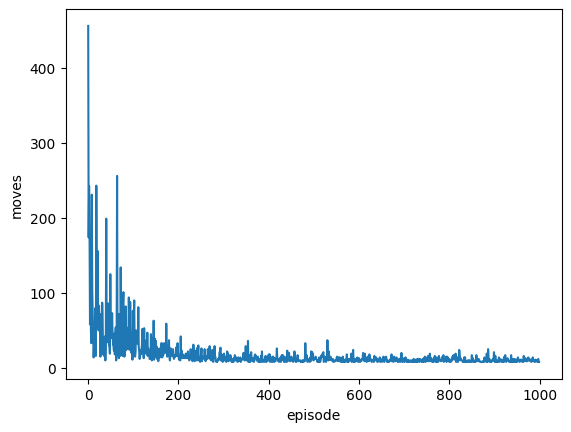

In [ ]:
plt.plot(total_moves)
plt.xlabel('episode')
plt.ylabel('moves')
plt.show()

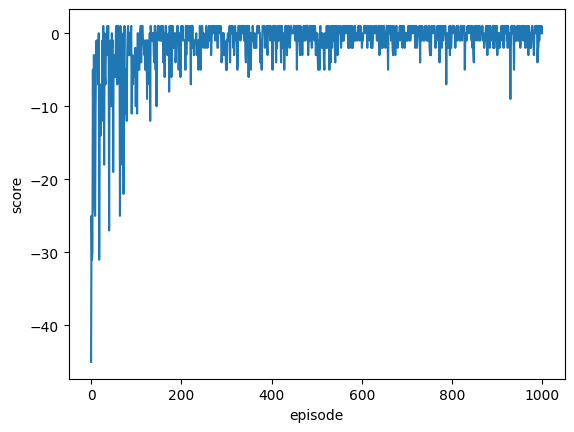

In [ ]:
plt.plot(scores)
plt.xlabel('episode')
plt.ylabel('score')
plt.show()